# Homework 2: SVMs, Kernels & Logistic Regression

## 1. Support Vector Machines: SVMs with Pegasos

### Subgradients

1. Suppose $f_1, ..., f_m: \mathbb{R}^d \rightarrow \mathbb{R}$ are convex functions, and $f(x) = max_{i = 1, ..., m}(x)$. Let k be any index for which $f_k(x) = f(x)$ and choose $g \in \partial f_k(x)$. Show that $g \in \partial f(x)$.

    $$\because g \in \partial f_k(x)$$
    $\forall z$,
    $$f_k(z) \geq f(x) + g^T(z - x)$$
    $$and \because f(x) = max_{i = 1, ..., m}(x)$$
    $$f(z) \geq f_k(z)$$
    $\forall z$,
    $$f(z) \geq f(x) + g^T(z - x)$$
    That is $g \in \partial f(x)$.

2. Give a subgradient of the hinge loss objective $J(w) = max{0, 1 - yw^tx}$
    $$\partial J(w) = -yx$$

### SVM with the Pegasos algorithm

3. Consider the SVM objective function for a single training point: $J_i(w) = \frac{\lambda}{2} \lVert w \rVert^2 + \mathop{max}\{0, 1 - y_iw^Tx_i\}$. The function $J_i(w)$ is not differentiable everywhere. Specify where the gradient of $J_i(w)$ is not defined. Give an expression for the gradient where it is defined.

    When $y_iw^Tx = 1$, the gradient of $J_i(w)$ is not defined.
    $$\nabla_w J_i(w) = \left\{
        \begin{aligned}
            \lambda w, y_iw^Tx &> 1 \\
            \lambda w - y_ix_i, y_iw^Tx &< 1
        \end{aligned}
    \right. $$

4. Show that a subgradient of $J_i(w)$ is given by
    $$gw = \left\{
        \begin{aligned}
            \lambda w, y_iw^Tx &\ge 1 \\
            \lambda w - y_ix_i, y_iw^Tx &< 1
        \end{aligned}
    \right. $$

    Obviously, $\partial\frac{\lambda}{2} \lVert w \rVert^2 = \lambda w$
    By using the factor from 1, 
    $$
    \begin{aligned}
    \partial max\{0, 1 - y_iw^Tx_i\} &= \left\{
        \begin{aligned}
            \partial (1 - y_iw^Tx), y_iw^Tx &\ge 1 \\
            \partial (0), y_iw^Tx &< 1
        \end{aligned}
    \right. ,\because J_i(w) = \left\{
        \begin{aligned}
            1 - y_iw^Tx, y_iw^Tx &\ge 1 \\
            0, y_iw^Tx &< 1
        \end{aligned}
    \right. \\
    &= \left\{
        \begin{aligned}
            -y_ix_i, y_iw^Tx &\ge 1 \\
            0, y_iw^Tx &< 1
        \end{aligned}
    \right.
    \end{aligned}
    $$
    based on factor 1 given by the problem and 
    $$J_i(w) = \frac{\lambda}{2} \lVert w \rVert^2 + \mathop{max}\{0, 1 - y_iw^Tx_i\}$$
    $$\partial J_i(w) = \partial\frac{\lambda}{2} \lVert w \rVert^2 + \partial max\{0, 1 - y_iw^Tx_i\}$$
    which is
    $$\partial J_i(w) = \left\{
        \begin{aligned}
            \lambda w, y_iw^Tx &\ge 1 \\
            \lambda w - y_ix_i, y_iw^Tx &< 1
        \end{aligned}
    \right. $$
    

### Dataset and sparse representation

5. Write a function that converts an example (a list of words) into a sparse bag-of-words representation. You may ﬁnd Python’s Counter 3 class to be useful here. Note that a Counter is itself a dictionary.

In [125]:
import sys
import os
from collections import Counter
import random
import time
import functools
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize

sys.path.append(os.path.relpath("./svm"))
import utils_svm_reviews

In [126]:
def data2dic(data):
    cnt = Counter(data)
    return cnt

6. Load all the data and split it into 1500 training examples and 500 validation examples. Format the training data as a list X train of dictionaries and y train as the list of corresponding 1 or -1 labels. Format the test set similarly.

In [127]:
X = []
y = []

for root, dirs, files in os.walk("./data_reviews/neg", topdown=False):
    for name in files:
        p = os.path.join(root, name)
        data = utils_svm_reviews.read_data(p)
        dic = data2dic(data)
        X.append(dic)
        y.append(-1)


for root, dirs, files in os.walk("./data_reviews/pos", topdown=False):
    for name in files:
        p = os.path.join(root, name)
        data = utils_svm_reviews.read_data(p)
        dic = data2dic(data)
        X.append(dic)
        y.append(1)

zipped = list(zip(X, y))
random.shuffle(zipped)
X, y = zip(*zipped)

X_train = X[:1500]
y_train = y[:1500]
X_test = X[1500:]
y_test = y[1500:]

7. Implement the Pegasos algorithm to run on a sparse data representation.

In [128]:
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale

In [129]:
def pegasos_alg1(X_train, y_train, lambda_reg, num_step=1):
    w = {}
    t = 1
    for epoch in range(num_step):
        for i in range(len(X_train)):
            t += 1
            eta = 1 / t / lambda_reg
            ans = y_train[i] * dotProduct(X_train[i], w)
            increment(w, -eta * lambda_reg, w)
            if ans < 1:
                increment(w, eta * y_train[i], X_train[i])
    return w

w1 = pegasos_alg1(X_train, y_train, 0.01)
len(w1)

27218

8. Implement the Pegasos algorithm with the (s, W) representation described above.

In [130]:
def pegasos_alg2(X_train, y_train, lambda_reg, num_step=1):
    w = {}
    s = 1
    W = {}
    t = 1
    for epoch in range(num_step):
        for i in range(len(X_train)):
            # t starts at 2
            t += 1
            eta = 1 / t / lambda_reg
            s = (1 - eta * lambda_reg) * s

            ans = y_train[i] * dotProduct(X_train[i], W) * s
            if ans < 1:
                increment(W, 1 / s * eta * y_train[i], X_train[i])

    increment(w, s, W)
    return w

w2 = pegasos_alg2(X_train, y_train, 0.01)
len(w2)

27218

In [131]:
print(w1.__str__()[:200])
print(w2.__str__()[:200])

{'all': -3.4643570952698304, 'right': 1.065956029313793, 'we': 2.3317788141239197, 'get': -2.13191205862758, 'the': -0.4663557628247857, 'point': -1.2658227848101289, 'despite': 0.73284477015323, 'sim
{'all': -3.464357095269825, 'right': 1.0659560293137909, 'we': 2.331778814123919, 'get': -2.131912058627585, 'the': -0.4663557628247651, 'point': -1.2658227848101282, 'despite': 0.7328447701532312, 's


As shown in the cell above, the output of 2 calculate ways are almost the same.

9. Run both implementations of Pegasos on the training data for a couple epochs. Make sure your implementations are correct by verifying that the two approaches give essentially the same result. Report on the time taken to run each approach.

In [132]:
start_time = time.time()
w1 = pegasos_alg1(X_train, y_train, 0.01)
print("approach 1 used: {}".format(time.time() - start_time))

start_time = time.time()
w2 = pegasos_alg2(X_train, y_train, 0.01)
print("approach 2 used: {}".format(time.time() - start_time))

approach 1 used: 2.4726672172546387
approach 2 used: 0.08680081367492676


10. Write a function `classification_error` that takes a sparse weight vector $w$, a list of sparse vectors $X$ and the corresponding list of labels $y$, and returns the fraction of errors when predicting $y_i$ using $sign(w^Tx_i)$. In other words, the function reports the 0-1 loss of the linear predictor $f(x) = w^Tx$.

In [133]:
def classification_error(X, y, w):
    num = len(X)
    err_count = 0
    for i in range(num):
        if (y[i] * dotProduct(w, X[i]) < 0):
            err_count += 1
    return err_count / num

classification_error(X_test, y_test, w2)

0.388

11. Search for the regularization parameter that gives the minimal percent error on your test set. You should now use your faster Pegasos implementation, and run it to convergence. A good search strategy is to start with a set of regularization parameters spanning a broad range of orders of magnitude. Then, continue to zoom in until you’re convinced that additional search will not signiﬁcantly improve your test performance. Plot the test errors you obtained as a function of the parameters $\lambda$ you tested. (Hint: the error you get with the best regularization should be closer to 15% than 20%. If not, maybe you did not train to convergence.)

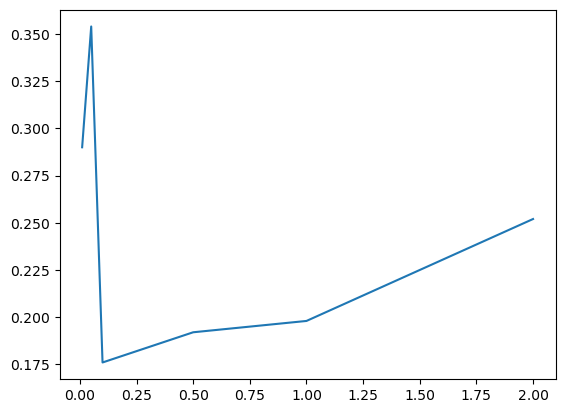

In [134]:
lambda_list = [0.01, 0.05, 0.1, 0.5, 1, 2]
err_list = []
for l in lambda_list:
    w = pegasos_alg2(X_train, y_train, lambda_reg=l, num_step=20)
    err = classification_error(X_test, y_test, w)
    err_list.append(err)

plt.plot(lambda_list, err_list)

12. Break the predictions on the test set into groups based on the score (you can play with the size of the groups to get a result you think is informative). For each group, examine the percentage error. You can make a table or graph. Summarize the results. Is there a correlation between higher magnitude scores and accuracy?

In [135]:
w = pegasos_alg2(X_train, y_train, lambda_reg=0.01, num_step=30)

In [136]:
score_list = []
for x, y in zip(X_test, y_test):
    score_list.append(abs(dotProduct(w, x)))

score_list, X_sorted, y_sorted = zip(*sorted(zip(score_list, X_test, y_test)))

step_size = 20
score_list = [sum(score_list[i:i + step_size]) for i in range(0, len(score_list), step_size)]
err_list = [classification_error(X_sorted[i:i + step_size], y_sorted[i:i + step_size], w) for i in range(0, len(y_test), step_size)]

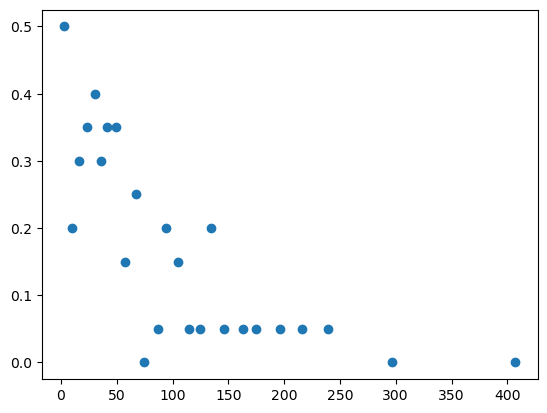

In [137]:
plt.scatter(score_list, err_list)

As we can see from the scatterplot, from the total score and the accuracy of the groups, the larger the score is, the lower the error rate will be.

## 2. Kernel Methods

### Kernels and Kernel Machines

13. Write functions that compute the kernels.

In [138]:
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))
 
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    n1, _ = X1.shape
    n2, _ = X2.shape
    ret = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            x1 = X1[i]
            x2 = X2[j]
            ret[i][j] = np.exp(-np.sum((x1 - x2) ** 2) / sigma ** 2 / 2)
    return ret


def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    n1, _ = X1.shape
    n2, _ = X2.shape
    ret = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            x1 = X1[i]
            x2 = X2[j]
            ret[i][j] = np.power(offset + np.dot(x1, x2.T), degree)
    return ret


14. Use the linear kernel function deﬁned in the code to compute the kernel matrix on the set of points $x_0 \in D_x = \{ −4, −1, 0, 2 \}$. Include both the code and the output.

In [139]:
x0 = np.array([-4, -1, 0, 2]).reshape((4, 1))

linear_kernel(X1=x0, X2=x0)

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

15. 

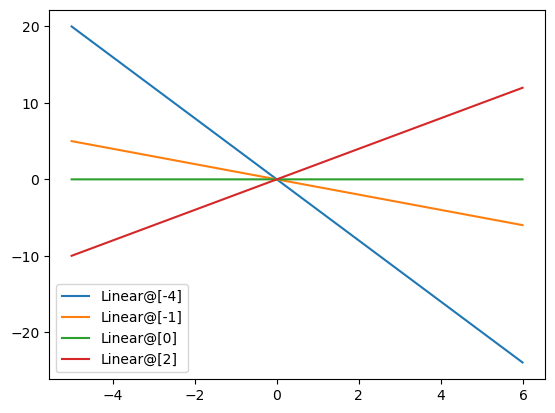

In [140]:
# PLot kernel machine functions

plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show()

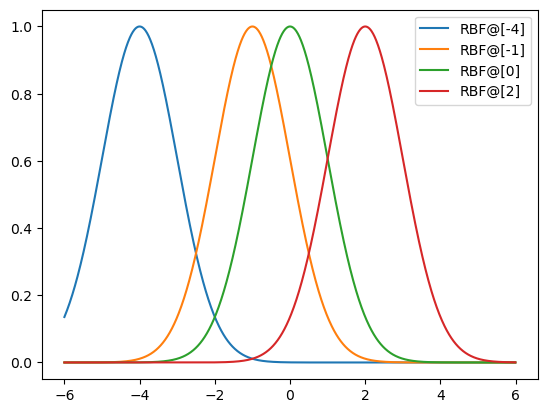

In [141]:
plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# RBF Kernel
y = RBF_kernel(prototypes, xpts, 1)
for i in range(len(prototypes)):
    label = "RBF@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show()

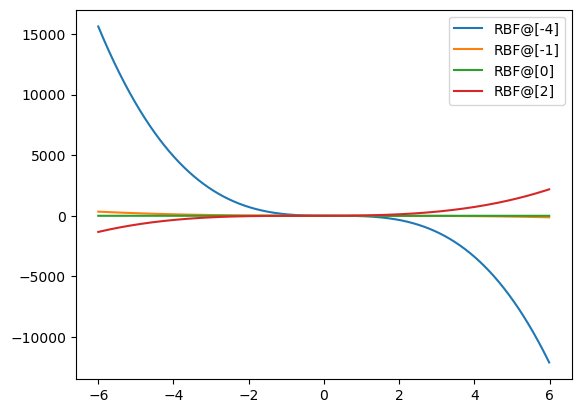

In [142]:
plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# polynomial Kernel
y = polynomial_kernel(prototypes, xpts, 1, 3)
for i in range(len(prototypes)):
    label = "RBF@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show()

16. Construct a Kernel Machine object with the RBF kernel (sigma=1), with prototype points at −1, 0, 1 and corresponding weights $\alpha_i$ 1, −1, 1. Plot the resulting function.

In [143]:
class Kernel_Machine(object):
    def __init__(self, kernel, training_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            training_points - an nxd matrix with rows x_1,..., x_n
            weights - a vector of length n with entries alpha_1,...,alpha_n
        """

        self.kernel = kernel
        self.training_points = training_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.
            Specifically, jth entry of return vector is
            Sum_{i=1}^R alpha_i k(x_j, mu_i)
        """
        n1 = self.training_points.shape[0]
        n2 = X.shape[0]
        ret = np.zeros((n1, n2))
        for i in range(len(self.weights)):
            ret += self.weights[i] * self.kernel(self.training_points[i:i + 1, :], X)
        return ret

kernel = functools.partial(RBF_kernel, sigma=1)
training_points = np.array([-1, 0, 1]).reshape(-1, 1)
weights = np.array([1, -1, 1])
km = Kernel_Machine(kernel=kernel, training_points=training_points, weights=weights)
km.predict(training_points)

array([[0.52880462, 0.21306132, 0.52880462],
       [0.52880462, 0.21306132, 0.52880462],
       [0.52880462, 0.21306132, 0.52880462]])

## 3. Logistic Regression

### Equivalence of ERM and probabilistic approaches

17. Show that the two approaches are equivalent, i.e. they will produce the same solution for $w$.

    as given in the MLE part, 
    $$p(y = 1 \vert x;w) = \frac 1 {1 + exp(-x^Tw)}$$
    the likelihood function is
    $$L = \prod_{i = 1}^N(\frac 1 {1 + exp(-x^Tw)})^{\frac {1 + y_i} 2} (1 - \frac 1 {1 + exp(-x^Tw)})^{\frac {1 - y_i} 2}$$
    which is
    $$L = \prod_{i = 1}^N(\frac 1 {1 + exp(-x^Tw)})^{\frac {1 + y_i} 2} (\frac 1 {1 + exp(x^Tw)})^{\frac {1 - y_i} 2}$$
    we calculate log-likelihood, the result is
    $$log(L) = - \sum_{i = 1}^N (\frac{1 + y_i}2 log(1 + exp(-w^Tx)) + \frac{1 - y_i}2 log(1 + exp(w^Tx)))$$
    since $y_i \in {-1, 1}$, the equation above can be represented as
    $$log(L) = - \sum_{i = 1}^N log(1 + exp(-y_iw^Tx))$$
    we need to maximize the log of likelihood function, which is minimize the negative log-likelihood, which is the same as the logistic loss.

### Linearly Separable Data

18. Show that the decision boundary of logistic regression is given by $\{x: x^Tw = 0\}$. Note that the set will not change if we multiply the weights by some constant c.

    as given before, $p(y = 1 \vert x;w) = \frac 1 {1 + exp(-x^Tw)}$
    to predict true, the output of the logistic regression will be greater than 0.5, so the boundary is
    $$\frac 1 {1 + exp(-x^Tw)} > 0.5$$
    which is 
    $$1 + exp(-x^Tw) < 2$$
    $$exp(-x^Tw) < 1$$
    which is
    $$x^Tw > 0$$
    meaning that when predicting a possitive result, the value of $w^Tx$ must be greater than 0, and to predict a negative result we need $w^Tx$ to be smaller than 0. So the decision boundary of logistic regression is given by $\{x: x^Tw = 0\}$.

19. Suppose the data is linearly separable and by gradient descent/ascent we have reached a decision boundary defined by $\hat w$ where all examples are classiﬁed correctly. Show that we can always increase the likelihood of the data by multiplying a scalar $c$ on $\hat w$, which means that MLE is not well-deﬁned in this case.

    $$L(c\hat w) = \sum_{i = 1}^n log(1 + e^{-y_i(c\hat w_i)^Tx_i})$$
    $$\frac {\partial L} {\partial c} = \sum_{i = 1}^n \frac {-y_i\hat w_i^Tx_ie^{-y_i(c\hat w_i)^Tx_i}}{1 + e^{-y_i(c\hat w_i)^Tx_i}} < 0$$
    Since data linearly separable, all the terms are negative and $c \rarr L(c\hat w)$ is a decreasing function of $c$ on $R$. Can always increase the value of $L(c\hat w)$ by choosing a smaller $c' < c$.

### Regularized Logistic Regression

20. Prove that the objective function $J_{logistic}(w)$ is convex. You may use any facts mentioned in the convex optimization notes.

    $$\frac {\partial L} {\partial w} = \sum_{i = 1}^n \frac {-y_ix_ie^{-y_i w^Tx_i}}{1 + e^{-y_i w^Tx_i}} + 2 \lambda w$$

    $$
    \begin{aligned}
    \frac {\partial L^2} {\partial w^2} &= \sum_{i = 1}^n \frac {y_i^2x_i^Tx_i(1 + e^{-y_iw^Tx_i}) - y_i^2x_i^Tx_ie^{-2y_iw^Tx}}{1 + e^{-y_i w^Tx_i}} + 2 \lambda \\
    &= \sum_{i = 1}^n \frac {y_i^2x_i^Tx_ie^{-y_iw^Tx_i}(1 + e^{-y_iw^Tx_i}) - y_i^2x_i^Tx_ie^{-2y_iw^Tx}}{(1 + e^{-y_i w^Tx_i})^2} + 2 \lambda \\
    &= \sum_{i = 1}^n \frac {y_i^2x_i^Tx_ie^{-y_iw^Tx_i}}{(1 + e^{-y_i w^Tx_i})^2} + 2 \lambda \\
    &> 0
    \end{aligned}
    $$

    which means that the original function is a convex function.

21. Complete the `f_objective` function in the skeleton code, which computes the objective function for $J_{logistic}(w)$.

In [144]:
def f_objective(theta, X, y, l2_param=1):
    '''
    Args:
        theta: 1D numpy array of size num_features
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        l2_param: regularization parameter

    Returns:
        objective: scalar value of objective function
    '''
    j = 0
    num_instances, num_features = X.shape
    for i in range(num_instances):
        j = np.logaddexp(j, np.log(1 + np.exp(-y[i] * np.sum(X[i] * theta))))

    j /= num_instances
    j += l2_param * np.sum(theta * theta)
    return j


22. Complete the `fit_logistic_reg` in the skeleton code using the `minimize` function from `scipy.optimize`. Use this function to train a model on the provided data. Make sure to take the appropriate preprocessing steps, such as standardizing the data and adding a column for the bias term.

In [145]:
def fit_logistic_reg(X, y, objective_function, l2_param=1):
    '''
    Args:
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        objective_function: function returning the value of the objective
        l2_param: regularization parameter
        
    Returns:
        optimal_theta: 1D numpy array of size num_features
    '''
    theta0 = np.zeros(X.shape[1])
    result = minimize(objective_function, theta0, args=(X, y, l2_param))
    
    return result

In [146]:
data_train,data_test = np.loadtxt("./svm/krr-train.txt"),np.loadtxt("./svm/krr-test.txt")
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

In [147]:
X_train = np.loadtxt("./logreg/X_train.txt", delimiter=',')
X_test = np.loadtxt("./logreg/X_val.txt", delimiter=',')
y_train = np.loadtxt("./logreg/y_train.txt", delimiter=',')
y_test = np.loadtxt("./logreg/y_val.txt", delimiter=',')

23. Find the $l_2$ regularization parameter that minimizes the log-likelihood on the validation set. Plot the log-likelihood for diﬀerent values of the regularization parameter.

In [148]:
l2_params = [0.01, 0.02, 0.05, 0.1, 0.5, 1]
objective = []
for l2_param in l2_params:
    result = fit_logistic_reg(X_train, y_train, f_objective, l2_param=l2_param)
    theta = result.x
    objective.append(f_objective(theta, X_test, y_test, l2_param=l2_param))

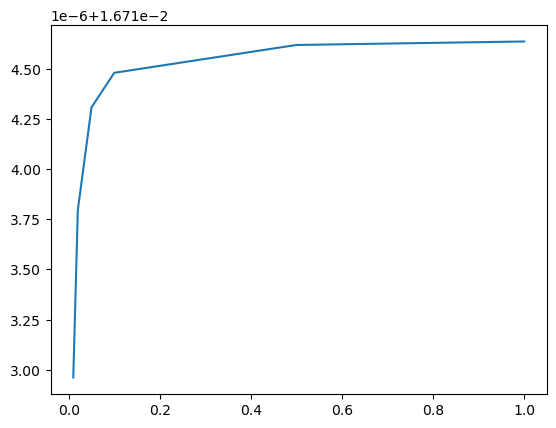

In [149]:
plt.plot(l2_params, objective)